# HOMEWORK 4

### Rishab Lokray  9357-3447

### Import Statements.

In [157]:
import pandas as pd
import numpy as np
from random import seed
from math import sqrt
import matplotlib.pyplot as plt
import os, sys, getopt, pdb
from numpy import *
from numpy.linalg import *
from numpy.random import *
from scipy.sparse import linalg, eye
from sklearn.neighbors import NearestNeighbors


cluster_data = np.loadtxt('clusters.txt') 
swissroll_data = np.loadtxt('swissroll.txt')
halfmoons_data = np.loadtxt('halfmoons.txt')


# Multi Dimensional Scaling

In [158]:
def MDS(data,no_Clusters = 0):
    
    #Setting labelled as true as our clustering data has 3 classes.
    labels = True
    
    if no_Clusters == 0:
        labels = False
        
    D_matrix = pairwise_distances(data)
    
    # Number of points  
    no_points = len(D_matrix)
 
                                                                            
    h = np.eye(no_points) - np.ones((no_points, no_points))/no_points
 
    # Calculating B = YY^T                                                                                    
    B = -h.dot(D_matrix**2).dot(h)/2
 
    # Diagonalize                                                                             
    evals, evecs = np.linalg.eigh(B)
 
    # Sort by eigenvalues                                                  
    i     = np.argsort(evals)[::-1]
    evals = evals[i]
    evecs = evecs[:,i]
 
    # Computing the coordinates               
    W, = np.where(evals > 0)
    diag  = np.diag(np.sqrt(evals[W]))
    V  = evecs[:,W]
    Y  = V.dot(diag)
    
    projection = Y[:,:no_points + 1] 
    if labels:
        label = data[:,-1]
        for i in range(1,no_points+1):
            plt.plot(projection[label==i,0], projection[label==i, 1],'o')
        plt.axis('equal')
    else:
        plt.plot(projection[:,0], projection[:, 1],'bo')

    plt.title('Multi Dimensional Scaling')
    plt.show()

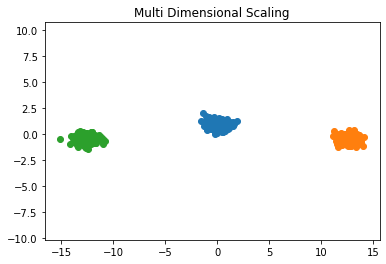

In [159]:
MDS(cluster_data, 3)

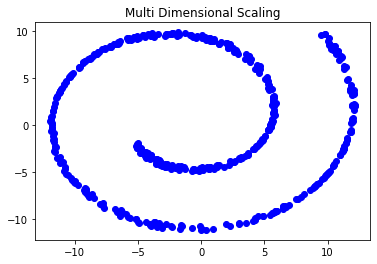

In [160]:
MDS(swissroll_data, 0)

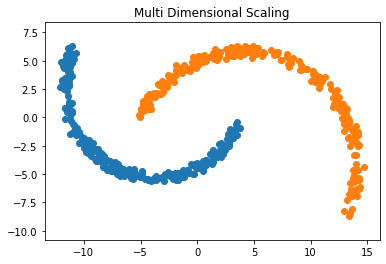

In [161]:
MDS(halfmoons_data, 2)

# ISO-MAP

In [162]:
#Helper function to calculate Distance Matrix
def distance_matrix(data, n_neighbors=3):
    
    # Function to calculate the eucilidian distance between two points.
    def dist(p1, p2):
        return np.sqrt(sum((p1 - p2)**2))

    # Compute full distance matrix
    full_distance_matrix = np.array([[dist(p1, p2) for p2 in data] for p1 in data])

    # Get the top 6 nearest neighbors.
    neighbors = np.zeros_like(full_distance_matrix)
    sort_distances = np.argsort(full_distance_matrix, axis=1)[:, 1:n_neighbors+1]
    
    for k,i in enumerate(sort_distances):
        neighbors[k,i] = full_distance_matrix[k,i]
    return neighbors, sort_distances

def isomap(ip_data, n=2, n_neighbors=5):
    
    data = ip_data[:, :-1]
    data, _ = distance_matrix(data, n_neighbors)

    # Compute Graph matrix from graph.
    
    from sklearn.utils.graph import graph_shortest_path
    graph_matrix = graph_shortest_path(data, directed=False)
    graph_matrix = -0.5 * (graph_matrix ** 2)
    
    # Return the MDS projection on the shortest paths graph
    label = True
    if n == 0:
        label = False
        
    
    D = graph_matrix
    
    # Number of points                                                                        
    no = len(D)
 
    # Centering matrix                                                                        
    h = np.eye(no) - np.ones((no, no))/no
 
    # YY^T                                                                                    
    B = -h.dot(D**2).dot(h)/2
 
                                                                                 
    evals, evecs = np.linalg.eigh(B)
 
    # Sort by eigenvalue in descending order                                                  
    i   = np.argsort(evals)[::-1]
    evals = evals[i]
    evecs = evecs[:,i]
 
    # Compute the coordinates using positive-eigenvalued components only                      
    w, = np.where(evals > 0)
    L  = np.diag(np.sqrt(evals[w]))
    V  = evecs[:,w]
    Y  = V.dot(L)
    projection = Y[:,:no + 1] 
    
    if label:
        lab = ip_data[:,-1]
        for i in range(1,no+1):
            plt.plot(projection[lab==i,0], projection[lab==i, 1],'o')
        plt.axis('equal')
    else:
        plt.plot(projection[:,0], projection[:, 1],'o')

    plt.title('Isometric Mapping')
    plt.show()

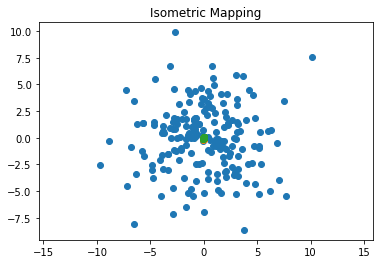

In [163]:
isomap(cluster_data, 3,15)

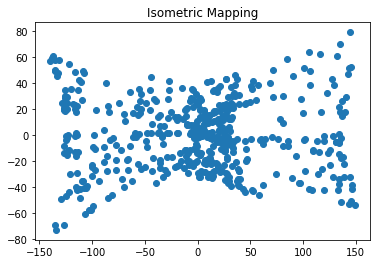

In [164]:
isomap(swissroll_data,0,10)

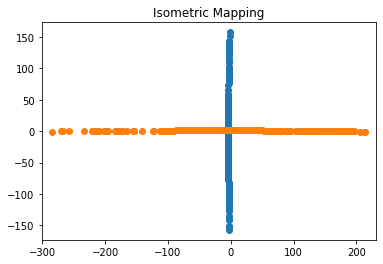

In [165]:
isomap(halfmoons_data,2,20)

# Locally Linear Embedding

In [180]:
def L_LE(knn,input_data, n,label = True):
    
    if label == True:
        data = input_data[:,:-1]
    else:
        data = input_data
        
    neighbor = NearestNeighbors(knn)
    neighbor.fit(data)
    _x,id=neighbor.kneighbors(data)
    N = len(data)
    M = len(data[0])
    id=id[:,1:]
    W = np.matrix(np.ones((N,N)) * 0)
    for i in range(N):
        v = np.matrix(np.ones((knn-1,M)))
        for j in range(knn-1):
            v[j] = data[id[i][j]]
        V=v.T       
        xi = []
        for j in range(knn-1):
            xi.append(data[i])
        xi=np.array(xi)
        xi=xi.T
        G=(xi-V).T@(xi-V)
        wi = np.linalg.inv(G).dot(np.ones(knn-1))
        wi=wi/np.sum(wi)
        wi=wi.T
        for j in range(len(id[0])):
            W[i,id[i,j]] = wi[j]
    M=(np.eye(N) - W.T)@((np.eye(N)-W.T).T)
   
    eigen_vals, eigen_vecs = np.linalg.eigh(M)
    eigen_vals = abs(eigen_vals)
    idx = np.argsort(eigen_vals)
    eigen_vals = eigen_vals[idx]
    eigen_vecs = eigen_vecs[:,idx]
    eigen_vecs = eigen_vecs[:,1:]
    y = eigen_vecs[:,:2]
    if label:
        l = input_data[:,-1]
        for i in range(1,n+1):
            plt.plot(y[l==i,0], y[l==i, 1],'o')
        plt.axis('equal');
    else:
        plt.plot(y[:,0], y[:, 1],'o')

    plt.title('Locally Linear Embedding')
    plt.show()

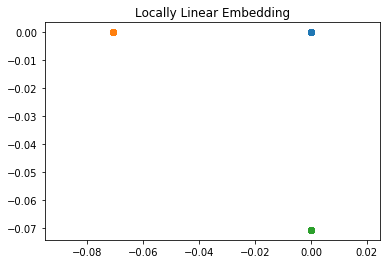

In [181]:
L_LE(10,cluster_data, 3,True)

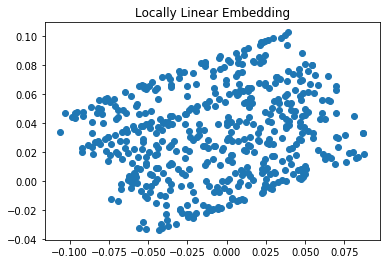

In [182]:
L_LE(15,swissroll_data,1,False)

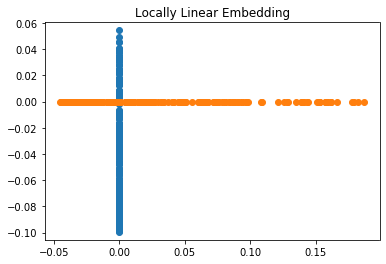

In [198]:
L_LE(17,halfmoons_data,2,True)

# Discussions

#### 1. Cluster Data Set

- Best method for this is **MDS** according to me. As MDS is good for clustered data.
- MDS is a visual representation of dissimilarities between sets of clusters 
- MDS is also a good approach for linear manifold which is not the case with the other two data sets.
- Isomap does not perform well for cluster data set as it is used for nonlinear manifolds. And clusters are not    continuous manifold data

#### 2. SwissRoll Data Set

- Best method for this is **LLE** 
- LLE performed well because lle works well at recognising non linear manifold and the data did not have a lot of holes so i prefered lle over isomap.

#### 3. Half Moons Data set

- Best method is **MDS** for half moons because it looks to perform better for clustered data and half moons has 2 classes. 